In [2]:
!nvidia-smi

Tue Sep 07 21:06:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108... WDDM  | 00000000:01:00.0  On |                  N/A |
| 25%   51C    P8    26W / 260W |    701MiB / 11264MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
from torch.utils.data import dataloader
from time import time
import datetime
import os
import sys
from collections import OrderedDict
from multiprocessing import Pool

device = torch.device('cuda:0')
print(device)

%matplotlib inline

cuda:0


In [4]:
def time_cost(func):
    def Wrapper(*arg, **kargs):
        t0 = time()
        res = func(*arg, **kargs)
        t1 = time()
        print(f'[{func.__name__}] cost {t1-t0:.2f}s')
        
        return res
    return Wrapper        

# Pretrain Models

In [5]:
from transformers import AutoTokenizer, BertModel
path = '../a_nlp_resource/transformers/bert-base-chinese/'
tokenizer = AutoTokenizer.from_pretrained(path)
bert = BertModel.from_pretrained(path).to(device)
bert.training

False

In [19]:
"""
vocab
"""
vocab = list(tokenizer.vocab.keys())

In [6]:
x = tokenizer(["我的太阳", '我'], 
           padding='max_length', 
           truncation=True, 
           max_length=20,
           return_tensors = 'pt'
           ).to(device)
y = bert(**x)
y[0][0].shape

torch.Size([20, 768])

In [7]:
y[0].reshape(2,-1).shape

torch.Size([2, 15360])

In [8]:
y[1].shape

torch.Size([2, 768])

In [9]:
tokenizer.mask_token

'[MASK]'

In [10]:
tokenizer.mask_token_id

103

In [11]:
tokenizer(["我的太阳", '我'], 
           padding='max_length', 
           truncation=True, 
           max_length=20,
           return_tensors = 'pt'
           ).to(device)

{'input_ids': tensor([[ 101, 2769, 4638, 1922, 7345,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 2769,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')}

In [78]:
tokenizer(["我的[MASK]阳[UNK]设"], 
           padding='max_length', 
           truncation=True, 
           max_length=20,
           return_tensors = 'pt'
           ).to(device)

{'input_ids': tensor([[ 101, 2769, 4638,  103, 7345,  100, 6392,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')}

In [80]:
tokenizer.vocab['[MASK]'], tokenizer.vocab['[UNK]']

(103, 100)

# Dataset

In [ ]:
class SimilarityDataProcessor:
    """
    处理如下类型数据集
    [q1 q2 label]

    [idx q1 q2 label]
    """

    def __init__(self, logger=print):
        self.logger = logger

    @time_cost
    def read_data(self,mode, name, path, sep, encoder='utf-8', has_index=False):
        """
        读取数据,返回 list形式的数据
        
        mode: 读取数据的方式, 
              readline 
              pandas 
        """
        self.logger(f'-'*42)
        self.logger(f'start to read: [{name}]...')
        
        if mode == 'readline':
            data = self._read_data_by_readline(path=path, 
                                         sep=sep, 
                                         encoder=encoder,
                                         has_index=has_index)
        elif mode == 'pandas':
            data = self._read_data_by_pandas(path=path, 
                                       sep=sep, 
                                       encoder=encoder)
        else:
            raise Exception('mode的值有误')
        
        # logs
        self.logger(f'finish reading: [{name}]')
        self.logger('nums:',len(data))
        for i in range(5):
            self.logger(data[i])
        return data
    
    
    def _read_data_by_readline(self, path, sep, encoder='utf-8', has_index=False):
        data = []
        with open(path, encoding=encoder) as f:
            line = f.readline()
            while line:
                try:
                    # 预处理
                    line = line.strip()
                    line = line.replace('\ufeff', '')

                    if has_index:
                        idx, q1, q2, label = line.split(sep)
                    else:
                        q1, q2, label = line.split(sep)
                    data.append([q1, q2, label])

                    line = f.readline()
                except Exception as e:
                    print(f'line: {line}')
                    print('-'*42)
                    print(e)
                    sys.exit()     
        return data
    
    
    def _read_data_by_pandas(self,path, sep, encoder='utf-8'):
        data = pd.read_csv(path, sep=sep, encoding=encoder)
        data = data.to_numpy().tolist()
        return data
        

    def create_dataloader(self, data, batch_size, is_shuffle):
        dataloader = torch.utils.data.DataLoader(data,
                                                 batch_size=batch_size,
                                                 shuffle=is_shuffle)
        return dataloader
    
    
    
    
    ############################################
    #预处理
    ############################################
    def preprocessing(self, text):
        """
        单句处理
        """
        global vocab
        
        res = ''
        for i in text: 
            # 大写字母vocab里面没有
            i = i.lower() 
            
            # punctuation 
            if i =='…': 
                i = '.'
            elif i in ["'",'‘','’','“','”']: 
                i = "'"
            elif i in ['—', '―', '—', '`']: # 注意'-'互相不一样
                i = ','
            
            # char
            char_correct = {
                '壋':'增', '笫':'第', '囙':'回',
                '呮':'呗', '嚒':'么', '睌':'晚',
                '谝':'骗', '鍀':'得', '昰':'是',
                '伲':'呢', '肔':'服', '凊':'清',
                '挷':'绑', '亊':'事', '腨':'用',
                '戗':'钱', '玏':'功', '筘':'扣',
                '鈤':'日', '颃':'领', '讠':'之',
                '扥':'在', '螚':'能', '甪':'用',
                '茌':'花', '泝':'没', '牫':'我',
                '孒':'了', '镸':'长', '欹':'款',
                '刭':'到', '幵':'开', '怩':'呢',
                '绐':'给', '弍':'式', '淸':'清',
                '夂':'久', '叧':'另', '徣':'借',
                '冋':'回', '敉':'粒', '埭':'贷',
                '仧':'卡', '頟':'额', '捿':'捷',
                '鳓':'嘞', '䃼':'补', '囯':'国',
                '吿':'告'
            }
            if i in char_correct:
                i = char_correct[i]
                    
            # nonsense letter
            if i in [' ', ' ', '　', '　',' ',' ',
                     chr(8198), chr(65039), chr(8237), chr(8236),  # 一串打出来都是空格
                     '\u200d', '\x08','', '', 
                     '∨', '乛','∵', chr(8198),]:
                continue
                
            # UNK
            if i not in vocab:
                self.logger(text,'|',ord(i),'|',i)
                i = '[UNK]' # 这个UNK后面的 tokenizer可以处理
                    
                
            res += i 
        
        return res  
    
   
    def preprocess_similarity_data(self, data):
        """
        预处理形如 [[q1_1,q2_1,label_1], [q1_2,q2_2,label_2]] 的数据
        """
        q1,q2,label = list(zip(*data))
        q1 = [self.preprocessing(q) for q in q1]
        self.logger('q1 处理完毕')
        q2 = [self.preprocessing(q) for q in q2]
        self.logger('q2 处理完毕')
        
        res = list(zip(q1,q2,label))
        return res
    
    @time_cost
    def multi(self, work_num, func, data):
        """
        目前函数输入只有 data 
        """
        per_lenght = len(data)//(work_num-1) # 最后还有一个尾巴余量给最后一个work

        p = Pool()
        p_res = []
        for i in range(work_num):
            begin = per_lenght*i
            end = per_lenght*(i+1)
            p_res.append(p.apply_async(func, args=(data[begin:end],)))
        p.close()
        p.join()
        
        res = []
        for i in range(work_num):
            res.append(p_res[i].get())
        
        # 当 data 是 [[q1_1,q2_1,label_1], [q1_2,q2_2,label_2]] 数据时
        res = [j for i in res for j in i]
        return res

    
    
    ##################################################
    # mask data
    ##################################################
    
    def get_masked_text(self, text):
        """
        生成masked后的输入inputs,
        和对应的输出标签 labels, 里面0代表不需要预测,在计算loss时需要忽略
        """
        global vocab,tokenizers

        inputs = ''
        labels = []

        for i in text:
            if i not in vocab:
                print(f'UNK | {text} | {ord(i)} | {i}')
                i = '[UNK]'
            
            # preprocessing
            r = np.random.random()
            i_id = tokenizer.vocab[i]
            if r <= 0.15*0.8:
                inputs += '[MASK]'
                labels.append(i_id)
            elif r <= 0.15*0.9:
                inputs += np.random.choice(list(text))
                labels.append(i_id)
            elif r <= 0.15:
                inputs += i
                labels.append(i_id)
            else:
                inputs += i
                labels.append(0)

        return inputs, labels
    
    @time_cost
    def get_masked_data(self, data):
        """
        data = [q1,q2,q3,...]
        """
        input_data = []
        labels = []
        
        for i in data:
            temp_input, temp_labels = self.get_masked_text(i)
            input_data.append(temp_input)
            labels.append(temp_labels)
            
        self.logger('Inputs & labels:')
        for i in range(5):
            self.logger(input_data[i])
            self.logger(labels[i])
    
        return input_data, labels
    
data_processor = SimilarityDataProcessor()

In [ ]:
data_processor = SimilarityDataProcessor(logger=print) 

## atec

In [71]:
atec = data_processor.read_data(mode='readline',
                                name='atec', 
                                path='../a_nlp_resource/dataset/ATEC/atec_nlp_sim_train.csv', 
                                sep='\t',
                                encoder='utf-8',
                                has_index=True)

atec_add = data_processor.read_data(mode='readline',
                                name='atec', 
                                path='../a_nlp_resource/dataset/ATEC/atec_nlp_sim_train_add.csv', 
                                sep='\t',
                                encoder='utf-8',
                                has_index=True)
atec = atec + atec_add

------------------------------------------
start to read: [atec]...
finish reading: [atec]
nums: 39346
['怎么更改花呗手机号码', '我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号', '1']
['也开不了花呗，就这样了？完事了', '真的嘛？就是花呗付款', '0']
['花呗冻结以后还能开通吗', '我的条件可以开通花呗借款吗', '0']
['如何得知关闭借呗', '想永久关闭借呗', '0']
['花呗扫码付钱', '二维码扫描可以用花呗吗', '0']
[read_data] cost 0.05s
------------------------------------------
start to read: [atec]...
finish reading: [atec]
nums: 63131
['为何我无法申请开通花呗信用卡收款', '支付宝开通信用卡花呗收款不符合条件怎么回事', '1']
['花呗分期付款会影响使用吗', '花呗分期有什么影响吗', '0']
['为什么我花呗没有临时额度', '花呗没有临时额度怎么可以负', '0']
['能不能开花呗老兄', '花呗逾期了还能开通', '0']
['我的怎么开通花呗收钱', '这个花呗是个什么啥？我没开通 我怎么有账单', '0']
[read_data] cost 0.08s


In [73]:
atec = data_processor.preprocess_similarity_data(atec)

q1 处理完毕
q2 处理完毕


## bq_corpus

In [74]:
path = './data/bq_corpus/'
bq_corpus_train = data_processor.read_data(mode='pandas',
                                           name='bq_corpus_train', 
                                           path=path+'train.csv', 
                                           sep=',',
                                           encoder='utf-8')

bq_corpus_val = data_processor.read_data(mode='pandas',
                                         name='bq_corpus_val', 
                                         path=path+'dev.csv', 
                                         sep=',',
                                         encoder='utf-8')

bq_corpus_test = data_processor.read_data(mode='pandas',
                                          name='bq_corpus_test', 
                                          path=path+'test.csv', 
                                          sep=',',
                                          encoder='utf-8')

------------------------------------------
start to read: [bq_corpus_train]...
finish reading: [bq_corpus_train]
nums: 100000
['用微信都6年，微信没有微粒贷功能', '4。  号码来微粒贷', 0]
['微信消费算吗', '还有多少钱没还', 0]
['交易密码忘记了找回密码绑定的手机卡也掉了', '怎么最近安全老是要改密码呢好麻烦', 0]
['你好 我昨天晚上申请的没有打电话给我 今天之内一定会打吗？', '什么时候可以到账', 0]
['“微粒贷开通"', '你好，我的微粒贷怎么没有开通呢', 0]
[read_data] cost 0.21s
------------------------------------------
start to read: [bq_corpus_val]...
finish reading: [bq_corpus_val]
nums: 10000
['不要借了我是试试看能否操作的', '借款审核期间能否取消借款', 0]
['亲怎样才能在钱包里有微粒货的图标呢', '借不到', 0]
['你好，我还款银行怎么更换', '怎么更换绑定还款的卡', 1]
['我的借贷额度，怎么减少了呢？', '微粒贷额度怎么才能降低', 0]
['什么时候可以知道借款成功', '2.多笔借款', 0]
[read_data] cost 0.02s
------------------------------------------
start to read: [bq_corpus_test]...
finish reading: [bq_corpus_test]
nums: 10000
['为什么我无法看到额度', '为什么开通了却没有额度', 0]
['为啥换不了', '为两次还都提示失败呢', 0]
['借了钱，但还没有通过，可以取消吗？', '可否取消', 1]
['为什么我申请额度输入密码就一直是那个页面', '为什么要输入支付密码来验证', 0]
['今天借 明天还款可以？', '今天借明天还要手续费吗', 0]
[read_data] cost 0.02s


In [122]:
bq_corpus_train = data_processor.preprocess_similarity_data(bq_corpus_train)

q1 处理完毕
q2 处理完毕


In [120]:
bq_corpus_train

[['用微信都6年，微信没有微粒贷功能', '4。  号码来微粒贷', 0],
 ['微信消费算吗', '还有多少钱没还', 0],
 ['交易密码忘记了找回密码绑定的手机卡也掉了', '怎么最近安全老是要改密码呢好麻烦', 0],
 ['你好 我昨天晚上申请的没有打电话给我 今天之内一定会打吗？', '什么时候可以到账', 0],
 ['“微粒贷开通"', '你好，我的微粒贷怎么没有开通呢', 0],
 ['为什么借款后一直没有给我回拨电话', '怎么申请借款后没有打电话过来呢！', 1],
 ['为什么我每次都提前还款了最后却不给我贷款了', '30号我一次性还清可以不', 0],
 ['请问一天是否都是限定只能转入或转出都是五万。', '微众多少可以赎回短期理财', 0],
 ['微粒咨询电话号码多少', '你们的人工客服电话是多少', 1],
 ['已经在银行换了新预留号码。', '我现在换了电话号码，这个需要更换吗', 1],
 ['下周有什么好产品？', '元月份有哪些理财产品', 1],
 ['第一次使用，额度多少？', '我的额度多少钱', 1],
 ['我什么时候可以通过微粒贷借钱', '提前还清贷款还能再借吗', 0],
 ['借款后多长时间给打电话', '借款后多久打电话啊', 1],
 ['没看到微粒贷', '我借那么久也没有提升啊', 0],
 ['原来的手机号不用了，怎么换', '手机号码没有更改', 1],
 ['我想开通微粒贷 不知我应该做写什么准备材料呢', '为何苹果手机显示微粒贷暂未开放？', 0],
 ['能查帐单吗', '可以查询帐单', 1],
 ['日利率多少', '息多少', 1],
 ['微信6.2的版本没有微粒贷吗？', '什么时候才会全面开放名额', 0],
 ['0K，谢谢，还没有开通', '开通为什么显示证件已被使用', 0],
 ['综合评估为何过不了', '为什么综合评分不能过?', 1],
 [':请问下我可以提额', '当月还清了，当月能提高额度吗', 0],
 ['1000多少一天', '10000借三天，总利息是163？', 1],
 ['为什么会有短信说审核不通过', '为什么借款回复是未通过了？', 1],
 ['借款不能用于什么', '借的款可以用来还信用卡吗？', 1],
 ['还款银行怎

In [53]:
bq_corpus_val = data_processor.preprocess_similarity_data(bq_corpus_val)

q1 处理完毕
q2 处理完毕


In [86]:
"""
test 数据集也可以处理, 不过只使用训练集的经验知识来处理
"""
bq_corpus_test = data_processor.preprocess_similarity_data(bq_corpus_test)

q1 处理完毕
q2 处理完毕


## build dataset

### mlm dataset

In [102]:
mlm_data = (list(zip(*bq_corpus_train))[0] 
            + list(zip(*bq_corpus_train))[1]
            + list(zip(*bq_corpus_val))[0]
            + list(zip(*bq_corpus_val))[1]
            + list(zip(*atec))[0]
            + list(zip(*atec))[1])
len(mlm_data)

424954

In [103]:
mlm_data = list(set(mlm_data))
print(len(mlm_data))
for i in range(5):
    print(mlm_data[i])

227877
花呗人脸验证，是本人为什么验证不了
借呗申请怎么填大学
今天蚂蚁借呗还款日到了，但没扣款
花呗如何重新绑定手机号
我每月都会提前还款，为什么我的蚂蚁借呗额度降低了


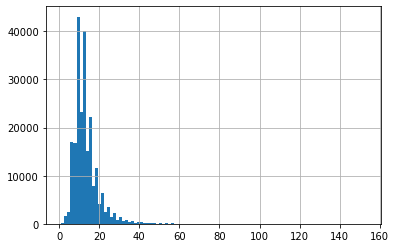

In [104]:
pd.Series(mlm_data).apply(lambda x : len(x)).hist(bins=100)

In [108]:
print(data_processor.get_masked_data('我的中国心'))
print(data_processor.get_masked_data('我的中国心'))
print(data_processor.get_masked_data('我的中国心'))

('我[MASK][MASK]国心', [0, 4638, 704, 0, 0])
('我的中国心', [0, 0, 0, 0, 0])
('我国中国心', [2769, 4638, 0, 0, 0])


In [118]:
mlm_input, mlm_label = data_processor.get_masked_data(mlm_data)

UNK | 可以审请吗 我咋没有 | 32 |  
UNK | 怎么抢iPhone7 | 80 | P
UNK | We支付如何开通 | 87 | W
UNK | 借款手续费 我其中一笔6000的借款手续费是多少 | 32 |  
UNK | 钱还了 还可以在借吗 | 32 |  
UNK | 如果借五千 那一天多少利息 | 32 |  
UNK | QQ钱包有微粒贷！如何关联 | 81 | Q
UNK | QQ钱包有微粒贷！如何关联 | 81 | Q
UNK | 一个月利息多少啊 为什么要扣173块多 | 32 |  
UNK | 你好 我想问下 我提前还全部款项的话 利息也是不减少的么 | 32 |  
UNK | 你好 我想问下 我提前还全部款项的话 利息也是不减少的么 | 32 |  
UNK | 你好 我想问下 我提前还全部款项的话 利息也是不减少的么 | 32 |  
UNK | 全额还款后 是否可以再次借款 | 32 |  
UNK | 因余额不足银行自动扣款失败 恢复余额 怎样还款 | 32 |  
UNK | 因余额不足银行自动扣款失败 恢复余额 怎样还款 | 32 |  
UNK | ……我的还款日是28号！为什么我28号早上还款进去了！会收到还款失败的短信 | 8230 | …
UNK | ……我的还款日是28号！为什么我28号早上还款进去了！会收到还款失败的短信 | 8230 | …
UNK | 为什么我有额度…借不出款来 | 8230 | …
UNK | 不能用手工还款 望解决 谢谢 | 32 |  
UNK | 不能用手工还款 望解决 谢谢 | 32 |  
UNK | ‍为‍什么‍开‍不了‍户 | 8205 | ‍
UNK | ‍为‍什么‍开‍不了‍户 | 8205 | ‍
UNK | ‍为‍什么‍开‍不了‍户 | 8205 | ‍
UNK | ‍为‍什么‍开‍不了‍户 | 8205 | ‍
UNK | ‍为‍什么‍开‍不了‍户 | 8205 | ‍
UNK | 。电话确认。 我没接到。 | 32 |  
UNK | 我QQ钱包里的微粒贷怎么消失了 | 81 | Q
UNK | 我QQ钱包里的微粒贷怎么消失了 | 81 | Q
UNK | 2 没我微粒贷可以申请吗 何时会邀请我使用微粒贷 1 | 32 |  
UNK | 2 没我微粒贷

UNK | 开通 借款 | 32 |  
UNK | ‍账单 | 8205 | ‍
UNK | 微信的微粒随心贷跟这个QQ的微粒贷是同一个平台嘛？ | 81 | Q
UNK | 微信的微粒随心贷跟这个QQ的微粒贷是同一个平台嘛？ | 81 | Q
UNK | 我贷了11000 20个月还清一共多缴纳多少利息 | 32 |  
UNK | 什么时候可以开始第二笔 借款 | 32 |  
UNK | 微众银行APP上可以借贷吗 | 65 | A
UNK | 微众银行APP上可以借贷吗 | 80 | P
UNK | 微众银行APP上可以借贷吗 | 80 | P
UNK | 我的身份证末尾数是x  正确方法怎么输入 | 32 |  
UNK | 我的身份证末尾数是x  正确方法怎么输入 | 32 |  
UNK | 为什么我第一次借款成功了，我提前还款后就不能借了呢 没有结果 | 32 |  
UNK | 以有APP登陆无法验证手机号 | 65 | A
UNK | 以有APP登陆无法验证手机号 | 80 | P
UNK | 以有APP登陆无法验证手机号 | 80 | P
UNK | 工商银行  身份证号  手机 | 32 |  
UNK | 工商银行  身份证号  手机 | 32 |  
UNK | 工商银行  身份证号  手机 | 32 |  
UNK | 工商银行  身份证号  手机 | 32 |  
UNK | 你好 为什么这个月没有自动还款 | 32 |  
UNK | QQ 安全中心怎么在手机QQ上登录 | 81 | Q
UNK | QQ 安全中心怎么在手机QQ上登录 | 81 | Q
UNK | QQ 安全中心怎么在手机QQ上登录 | 32 |  
UNK | QQ 安全中心怎么在手机QQ上登录 | 81 | Q
UNK | QQ 安全中心怎么在手机QQ上登录 | 81 | Q
UNK | 可以用其他银行卡还款或用QQ余额支付么？ | 81 | Q
UNK | 可以用其他银行卡还款或用QQ余额支付么？ | 81 | Q
UNK | 开通 额度 | 32 |  
UNK | QQ钱包是不是要实名认证呀 | 81 | Q
UNK | QQ钱包是不是要实名认证呀 | 81 | Q
UNK | 一期是多长时间 是一天吗？ | 32 |  
UNK | 菜单 微粒贷 | 

UNK | QQ 微粒贷也是这个吗 | 81 | Q
UNK | QQ 微粒贷也是这个吗 | 81 | Q
UNK | QQ 微粒贷也是这个吗 | 32 |  
UNK | 如何更改还款银行卡 我换手机机号 | 32 |  
UNK | 手机信号不好 可以打我另一个电话 | 32 |  
UNK | 24小时  过去了  还没来电话确认 | 32 |  
UNK | 24小时  过去了  还没来电话确认 | 32 |  
UNK | 24小时  过去了  还没来电话确认 | 32 |  
UNK | 24小时  过去了  还没来电话确认 | 32 |  
UNK | 不满足审批要求  需要怎么办才能满足是要求 | 32 |  
UNK | 不满足审批要求  需要怎么办才能满足是要求 | 32 |  
UNK | 三天了 还没打 | 32 |  
UNK | :为什么没有微粒贷 何时会邀请我使用微粒贷 如何获得微粒贷借款资格 | 32 |  
UNK | :为什么没有微粒贷 何时会邀请我使用微粒贷 如何获得微粒贷借款资格 | 32 |  
UNK | 在QQ上面没有 | 81 | Q
UNK | 在QQ上面没有 | 81 | Q
UNK | “绑定微信” | 8220 | “
UNK | “绑定微信” | 8221 | ”
UNK | 微信上有微粒贷，QQ上有微粒贷吗 | 81 | Q
UNK | 微信上有微粒贷，QQ上有微粒贷吗 | 81 | Q
UNK | 但是他又说我无法开通 但是信息已经都提示我已经开通了 | 32 |  
UNK | 手机QQ上没有借款 | 81 | Q
UNK | 手机QQ上没有借款 | 81 | Q
UNK | 我QQ怎么没微粒贷？ | 81 | Q
UNK | 我QQ怎么没微粒贷？ | 81 | Q
UNK | 这个和QQ微粒贷是共享的吗。还是各是各的 | 81 | Q
UNK | 这个和QQ微粒贷是共享的吗。还是各是各的 | 81 | Q
UNK | 不满意还款方式 我打算先还16000怎么操 | 32 |  
UNK | 借5000元 分10个月还 每月需要还多少？ | 32 |  
UNK | 借5000元 分10个月还 每月需要还多少？ | 32 |  
UNK | 为什么QQ上无法贷款 | 81 | Q
UNK | 为什么QQ

UNK | 微信微粒贷跟QQ是一起的吗… | 81 | Q
UNK | 微信微粒贷跟QQ是一起的吗… | 81 | Q
UNK | 微信微粒贷跟QQ是一起的吗… | 8230 | …
UNK | 贷款 信用卡 | 32 |  
UNK | 我身份验证输错了  就进不去了 | 32 |  
UNK | 我身份验证输错了  就进不去了 | 32 |  
UNK | 如果我还款成功…上哪可以开具证明 | 8230 | …
UNK | 你帮我开通吧 请帮我开通微粒贷吧 | 32 |  
UNK | 逾期2天利息 罚多少？ | 32 |  
UNK | 输入错误  无法接借款 | 32 |  
UNK | 输入错误  无法接借款 | 32 |  
UNK | 要下载微众银行APP吗 | 65 | A
UNK | 要下载微众银行APP吗 | 80 | P
UNK | 要下载微众银行APP吗 | 80 | P
UNK | 你好 问下借款的还款期限是多久 | 32 |  
UNK | 你好 如果还款 是不是到时候扣 | 32 |  
UNK | 你好 如果还款 是不是到时候扣 | 32 |  
UNK | “小粒”。等待电话确认大约得多 | 8220 | “
UNK | “小粒”。等待电话确认大约得多 | 8221 | ”
UNK | 为什么 我无法查看额度 | 32 |  
UNK | 2 申请 | 32 |  
UNK | 之前借了一笔没还清…现在又借一笔，还款日都是1号吗？ | 8230 | …
UNK | 4。  号码来微粒贷 | 32 |  
UNK | 4。  号码来微粒贷 | 32 |  
UNK | 为什么qq有图标  一直没有资格 | 32 |  
UNK | 为什么qq有图标  一直没有资格 | 32 |  
UNK | 你好 我借的款可以提现的吗？ | 32 |  
UNK | 我卡里一直有钱 你们一直扣款失败 关我屁事 如果算入征信 我一定会告你们 只通知了我一次 我还以为还款成功的 | 32 |  
UNK | 我卡里一直有钱 你们一直扣款失败 关我屁事 如果算入征信 我一定会告你们 只通知了我一次 我还以为还款成功的 | 32 |  
UNK | 我卡里一直有钱 你们一直扣款失败 关我屁事 如果算入征信 我一定会告你们 只通知了我一次 我还以为还款成功的

UNK | 20号卡内有钱 为什么还逾期 | 32 |  
UNK | 今天借钱  明天还要收利息吗 | 32 |  
UNK | 今天借钱  明天还要收利息吗 | 32 |  
UNK | QQ上的微粒贷客服号是真的吗 | 81 | Q
UNK | QQ上的微粒贷客服号是真的吗 | 81 | Q
UNK | 为什么款扣了 还说我逾期 | 32 |  
UNK | 能不能QQ红包换微信红包 | 81 | Q
UNK | 能不能QQ红包换微信红包 | 81 | Q
UNK | 何时能有资格开通 啊? | 32 |  
UNK | 我就是要做微粒贷 要什么时候邀请 | 32 |  
UNK | 你好，请问现在周末还可以买 国华月月盈 吗 | 32 |  
UNK | 你好，请问现在周末还可以买 国华月月盈 吗 | 32 |  
UNK | 开通 微粒贷开通 | 32 |  
UNK | 2500的日利率 一天是多少钱 | 32 |  
UNK | QQ在哪 | 81 | Q
UNK | QQ在哪 | 81 | Q
UNK | QQ微粒贷和微信微粒贷是一起的吗 | 81 | Q
UNK | QQ微粒贷和微信微粒贷是一起的吗 | 81 | Q
UNK | 提前的话是全额还清，是吧！就这两种选择…… | 8230 | …
UNK | 提前的话是全额还清，是吧！就这两种选择…… | 8230 | …
UNK | L为什么没有资 | 76 | L
UNK | 你好 我卡里余额足，想提前还款，但是总是提示还款失败。怎么回事？ | 32 |  
UNK | 如果还款好了款 会什么时候自动还款 | 32 |  
UNK | 微粒贷 关闭服务怎么做？ | 8197 |  
UNK | 我现在进入不了微众的APP | 65 | A
UNK | 我现在进入不了微众的APP | 80 | P
UNK | 我现在进入不了微众的APP | 80 | P
UNK | 怎么不能用零钱还款呀 3#加上零钱还款，不然用户转到零钱要还款 不能还，再往出转你还要扣钱。在还款你又要收利息。闹的用户，真很不开心。 | 32 |  
UNK | 怎么不能用零钱还款呀 3#加上零钱还款，不然用户转到零钱要还款 不能还，再往出转你还要扣钱。在还款你又要收利息。闹的用户，真很不开心。 | 32 |  
UNK | 【We

UNK | 微粒贷现在不是有买IPhone7的活动吗 | 73 | I
UNK | 微粒贷现在不是有买IPhone7的活动吗 | 80 | P
UNK | QQ上很微信是绑定的嘛 | 81 | Q
UNK | QQ上很微信是绑定的嘛 | 81 | Q
UNK | 你好 昨晚的电话没接到 | 32 |  
UNK | 我的卡上有钱 怎么还款失败 | 32 |  
UNK | 你好 如何提高我的信用额度 | 32 |  
UNK | 你好 我可以用微信余额还款吗 | 32 |  
UNK | 我没借款 没欠款 但需要关闭这个账户 | 32 |  
UNK | 我没借款 没欠款 但需要关闭这个账户 | 32 |  
UNK | ‍什么时候开通 | 8205 | ‍
UNK | 小w 能够邀请我开户吗 | 32 |  
UNK | 我微信更新到最新版本 也没有微粒贷呀 | 32 |  
UNK | QQ的微粒货是真的吗 | 81 | Q
UNK | QQ的微粒货是真的吗 | 81 | Q
UNK | 你好 请问下 我借款申请后，用一段时间 全部提前还，需要手续费吗 | 32 |  
UNK | 你好 请问下 我借款申请后，用一段时间 全部提前还，需要手续费吗 | 32 |  
UNK | 你好 请问下 我借款申请后，用一段时间 全部提前还，需要手续费吗 | 32 |  
UNK | 为什么 我不能申请 | 32 |  
UNK | 借了一次   未还款   额度还有的情况下可以再借吗？ | 32 |  
UNK | 借了一次   未还款   额度还有的情况下可以再借吗？ | 32 |  
UNK | 借了一次   未还款   额度还有的情况下可以再借吗？ | 32 |  
UNK | 借了一次   未还款   额度还有的情况下可以再借吗？ | 32 |  
UNK | 借了一次   未还款   额度还有的情况下可以再借吗？ | 32 |  
UNK | 借了一次   未还款   额度还有的情况下可以再借吗？ | 32 |  
UNK | 我不明白这个利息是怎么算的  我能借8500  按10还  一个月利息是多少 | 32 |  
UNK | 我不明白这个利息是怎么算的  我能借8500  按10还  一个月利息是多少 | 32 |  
UNK | 我不明白这个利息是怎么算

UNK | ‍如何获取资格 | 8205 | ‍
UNK | 今天是我的还款日 我可以下午把欠款打入银行卡嘛 | 32 |  
UNK | 微众银行APP吧是官方的？ | 65 | A
UNK | 微众银行APP吧是官方的？ | 80 | P
UNK | 微众银行APP吧是官方的？ | 80 | P
UNK | 你好 比如我借了2万 5个月分期 我能第二月就全还了么 利息怎么算啊 | 32 |  
UNK | 你好 比如我借了2万 5个月分期 我能第二月就全还了么 利息怎么算啊 | 32 |  
UNK | 你好 比如我借了2万 5个月分期 我能第二月就全还了么 利息怎么算啊 | 32 |  
UNK | 你好 比如我借了2万 5个月分期 我能第二月就全还了么 利息怎么算啊 | 32 |  
UNK | 我原来有微粒贷 但是现在钱包里没有了 我还能在借款吗 | 32 |  
UNK | 我原来有微粒贷 但是现在钱包里没有了 我还能在借款吗 | 32 |  
UNK | QQ上有微粒贷，显示综合评估未通过 | 81 | Q
UNK | QQ上有微粒贷，显示综合评估未通过 | 81 | Q
UNK | 在QQ里的微粒贷没额度 | 81 | Q
UNK | 在QQ里的微粒贷没额度 | 81 | Q
UNK | 开通 额度查询 | 32 |  
UNK | 请继续打电话 昨晚未接到电话 | 32 |  
UNK | 图标显示 好几个月了 怎么一直不能贷款 | 32 |  
UNK | 图标显示 好几个月了 怎么一直不能贷款 | 32 |  
UNK | 无论是用4g网还是连接wifi，始终无法登陆app…提示网络存在不安全因素… | 8230 | …
UNK | 无论是用4g网还是连接wifi，始终无法登陆app…提示网络存在不安全因素… | 8230 | …
UNK | QQ微粒贷，到账后可以直接提现吗，有手续费吗 | 81 | Q
UNK | QQ微粒贷，到账后可以直接提现吗，有手续费吗 | 81 | Q
UNK | We支付在哪里 | 87 | W
UNK | 呃 怎么关闭 | 32 |  
UNK | 开通 如何开 | 32 |  
UNK | 显示  身份信息输入错误次数过多，无法借款但是我没有输错过啊 | 32 |  
UNK | 显示  身份信息输入错误次数过

UNK | 上次借款 分六期 这次还能在借款么 | 32 |  
UNK | 上次借款 分六期 这次还能在借款么 | 32 |  
UNK | “钱没到帐” | 8220 | “
UNK | “钱没到帐” | 8221 | ”
UNK | 怎么进不了借钱截面 钱包里面没有 | 32 |  
UNK | 我申请借款后  怎么没有给我打电话 | 32 |  
UNK | 我申请借款后  怎么没有给我打电话 | 32 |  
UNK | QQ号,QQ有微粒贷，但是没成功！ | 81 | Q
UNK | QQ号,QQ有微粒贷，但是没成功！ | 81 | Q
UNK | QQ号,QQ有微粒贷，但是没成功！ | 81 | Q
UNK | QQ号,QQ有微粒贷，但是没成功！ | 81 | Q
UNK | 逾期罚金是·50％比如I00百是不是就要还150了 | 73 | I
UNK | 微信有微粒贷，QQ没有 | 81 | Q
UNK | 微信有微粒贷，QQ没有 | 81 | Q
UNK | 何时会邀请我使用微粒贷 微粒贷还没 | 32 |  
UNK | 单笔最多贷几万 一天最多货几万 | 32 |  
UNK | 我提交申请时 说身份信息输入错误次数过多 | 32 |  
UNK | 借了……多久可以到账 | 8230 | …
UNK | 借了……多久可以到账 | 8230 | …
UNK | 为什么不被邀请 怎么可以贷款 | 32 |  
UNK | 如何更改还款日期呢 您好 | 32 |  
UNK | QQ钱包在什么位置 | 81 | Q
UNK | QQ钱包在什么位置 | 81 | Q
UNK | 我已经申请过了，QQ还贷页面删除了 | 81 | Q
UNK | 我已经申请过了，QQ还贷页面删除了 | 81 | Q
UNK | 我的账单 怎么看 | 32 |  
UNK | QQ找不到微QQ钱包 | 81 | Q
UNK | QQ找不到微QQ钱包 | 81 | Q
UNK | QQ找不到微QQ钱包 | 81 | Q
UNK | QQ找不到微QQ钱包 | 81 | Q
UNK | 不是说还会再扣吗 干嘛不扣？这样算我逾期咯 | 32 |  
UNK | 如果 没收到钱算借吗 | 32 |  
UNK | 我有两个电话号码 怎样更改号码呢？ | 32 |  
UNK | Q

KeyboardInterrupt: 

### similarity dataset

#### exchange 

In [15]:
train = bq_corpus_train
train[:5]

[['用微信都6年，微信没有微粒贷功能', '4。  号码来微粒贷', 0],
 ['微信消费算吗', '还有多少钱没还', 0],
 ['交易密码忘记了找回密码绑定的手机卡也掉了', '怎么最近安全老是要改密码呢好麻烦', 0],
 ['你好 我昨天晚上申请的没有打电话给我 今天之内一定会打吗？', '什么时候可以到账', 0],
 ['“微粒贷开通"', '你好，我的微粒贷怎么没有开通呢', 0]]

In [61]:
train_change = list(zip(*train))
train_change = [train_change[1],train_change[0],train_change[2]]
train_change = list(zip(*train_change))
train_change[:5]

[('4。  号码来微粒贷', '用微信都6年，微信没有微粒贷功能', 0),
 ('还有多少钱没还', '微信消费算吗', 0),
 ('怎么最近安全老是要改密码呢好麻烦', '交易密码忘记了找回密码绑定的手机卡也掉了', 0),
 ('什么时候可以到账', '你好 我昨天晚上申请的没有打电话给我 今天之内一定会打吗？', 0),
 ('你好，我的微粒贷怎么没有开通呢', '“微粒贷开通"', 0)]

In [62]:
train = train+train_change
len(train)

200000

In [63]:
"""
val, test
"""
val = bq_corpus_val
test = bq_corpus_test

len(val), len(test)

(10000, 10000)

## dataloader

In [5]:
batch_size = 32

In [6]:
train_loader = data_processor.create_dataloader(train, 
                                                batch_size=batch_size, 
                                                is_shuffle=True)

val_loader = data_processor.create_dataloader(val, 
                                              batch_size=batch_size, 
                                              is_shuffle=False)

test_loader = data_processor.create_dataloader(test, 
                                               batch_size=batch_size, 
                                               is_shuffle=False)

NameError: name 'data_processor' is not defined

# MLM

In [70]:
model_config = {
    'max_len':50,
    'hidden_size':768,
    'embedding_size': 21128
}

In [ ]:
class MlmBert(nn.Module):
    def __init__(self):
        global bert, tokenizer, model_config
   
        self.final_part = nn.Sequential(OrderedDict([
            ('final_Linear', 
             nn.Linear(model_config['hidden_size'],model_config['hidden_size'], bias=True)),
            ('final_layernorm', 
             nn.LayerNorm(model_config['hidden_size'],eps=1e-12)),
            ('final_embedding', 
             nn.Linear(model_config['hidden_size'], model_config['embedding_size'], bias=False))  
        ]))
        
        embedding_p = [p for p in bert.embeddings.word_embeddings.parameters()][0].T
        final_part.final_embedding.weight.data=embedding_p
        

    def forward(self,q1,q2):
        
        
        
        return h   
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    def save(self, path='./sbert.model'):
        torch.save(self.state_dict(), path)
        
    def load(self, path='./sbert.model'):
        self.load_state_dict(torch.load(path)) 